## 5x5 Grid World
### Dynamic programming 을 적용하여 5x5 Grid World 에 대한 value function 및 policy 를 구하라.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

### GridWorld class

In [15]:
# import sys
# sys.path.append('/content/drive/MyDrive/강화학습') #google colab 경로 지정

import numpy as np
import common.gridworld5_render as render_helper

class GridWorld:
    def __init__(self):
        self.action_space = [0, 1, 2, 3]  # 행동 공간(가능한 행동들)
        self.action_meaning = {  # 행동의 의미
            0: "UP",
            1: "DOWN",
            2: "LEFT",
            3: "RIGHT",
        }

        self.reward_map = np.array(  # 보상 맵(각 좌표의 보상 값)
            [[0, 0, 0, -1.0, 1.0],
             [0, 0, 0, 0, 0],
             [0, None, None, 0, 0],
             [0, 0, 0, 0, -1.0],
             [0, 0, 0, 0, 0]
             ]
        )

        self.goal_state = (0, 4)    # 목표 상태(좌표)
        self.wall_state = [(2, 1), (2,2)]   # 2,1 2,2 # 벽 상태(좌표)
        self.start_state = (4, 0)   # 시작 상태(좌표)
        self.agent_state = self.start_state   # 에이전트 초기 상태(좌표)

    @property
    def height(self):
        return len(self.reward_map)

    @property
    def width(self):
        return len(self.reward_map[0])

    @property
    def shape(self):
        return self.reward_map.shape

    def actions(self):
        return self.action_space

    def states(self):
        for h in range(self.height):
            for w in range(self.width):
                yield (h, w)

    def next_state(self, state, action):
        # 이동 위치 계산
        action_move_map = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        move = action_move_map[action]
        next_state = (state[0] + move[0], state[1] + move[1])
        ny, nx = next_state

        # 이동한 위치가 그리드 월드의 테두리 밖이나 벽인가?
        if nx < 0 or nx >= self.width or ny < 0 or ny >= self.height:
            next_state = state
        elif next_state == self.wall_state[0] or next_state == self.wall_state[1]:
            next_state = state

        return next_state  # 다음 상태 반환

    def reward(self, state, action, next_state):
        if self.reward_map[next_state] == None:
            return 0

        return self.reward_map[next_state]

    def reset(self):
        self.agent_state = self.start_state
        return self.agent_state

    def step(self, action):
        state = self.agent_state
        next_state = self.next_state(state, action)
        reward = self.reward(state, action, next_state)
        done = (next_state == self.goal_state)

        self.agent_state = next_state
        return next_state, reward, done

    def render_v(self, v=None, policy=None, print_value=True):
        renderer = render_helper.Renderer(self.reward_map, self.goal_state,
                                          self.wall_state)
        renderer.render_v(v, policy, print_value)

    def render_q(self, q=None, print_value=True):
        renderer = render_helper.Renderer(self.reward_map, self.goal_state,
                                          self.wall_state)
        renderer.render_q(q, print_value)


### test code

In [16]:
env = GridWorld()

print(env.height)
print(env.width)
print(env.shape)

5
5
(5, 5)


In [17]:
for action in env.actions():
    print(action)

print('====================')

for state in env.states():
    print(state)

0
1
2
3
(0, 0)
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(1, 4)
(2, 0)
(2, 1)
(2, 2)
(2, 3)
(2, 4)
(3, 0)
(3, 1)
(3, 2)
(3, 3)
(3, 4)
(4, 0)
(4, 1)
(4, 2)
(4, 3)
(4, 4)


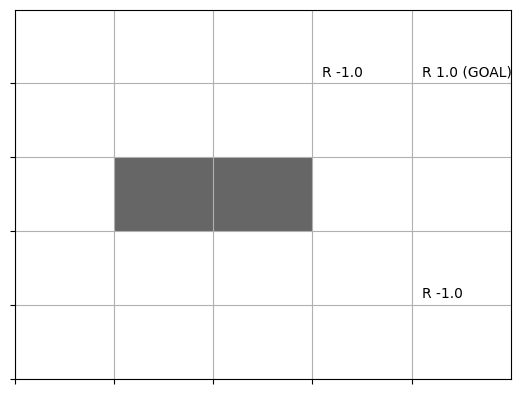

In [18]:
env = GridWorld()
env.render_v()


### GridWorld Play

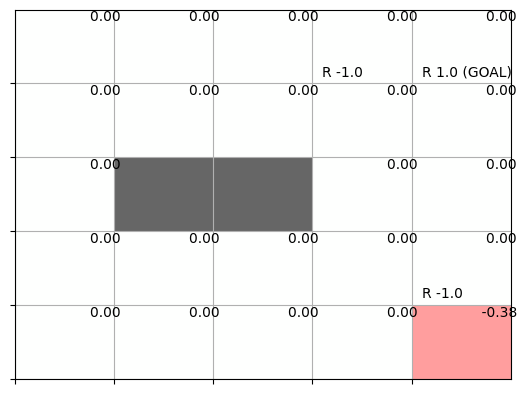

In [19]:
env = GridWorld()
V = {}
for stete in env.states():
    V[state] = np.random.randn()
env.render_v(V)

### Policy Evaluation

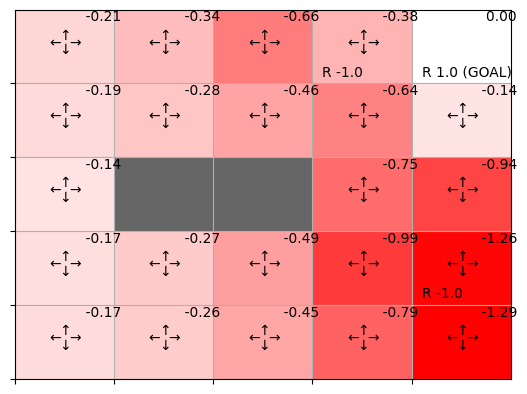

In [20]:
from collections import defaultdict

def eval_onestep(pi, V, env, gamma=0.9):
    for state in env.states():  # 각 상태에 접근
        if state == env.goal_state:  # 목표 상태에서의 가치 함수는 항상 0
            V[state] = 0
            continue

        action_probs = pi[state]
        new_V = 0

        # 각 행동에 접근
        for action, action_prob in action_probs.items():
            next_state = env.next_state(state, action)
            r = env.reward(state, action, next_state)

            # 새로운 가치 함수
            new_V += action_prob * (r + gamma * V[next_state])

        V[state] = new_V
    return V


def policy_eval(pi, V, env, gamma, threshold=0.001):
    while True:
        old_V = V.copy()  # 갱신 전 가치 함수
        V = eval_onestep(pi, V, env, gamma)

        # 갱신된 양의 최댓값 계산
        delta = 0
        for state in V.keys():
            t = abs(V[state] - old_V[state])
            if delta < t:
                delta = t

        # 임계값과 비교
        if delta < threshold:
            break
    return V


if __name__ == '__main__':
    env = GridWorld()
    gamma = 0.9  # 할인율

    pi = defaultdict(lambda: {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25})  # 정책
    V = defaultdict(lambda: 0)  # 가치 함수

    V = policy_eval(pi, V, env, gamma)  # 정책 평가

    env.render_v(V, pi)


### Policy iteration- 정책반복법

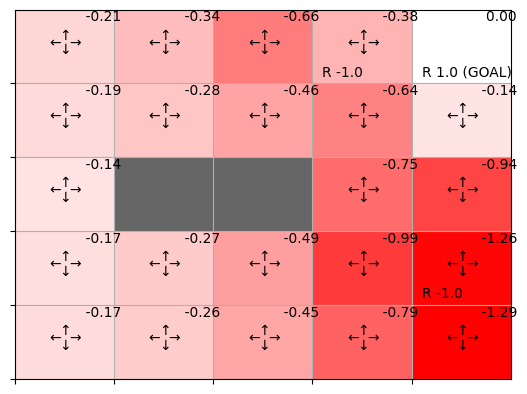

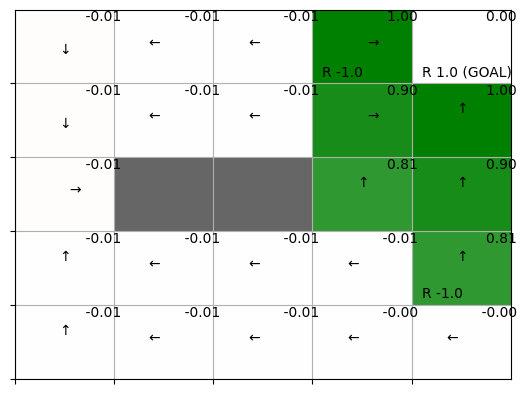

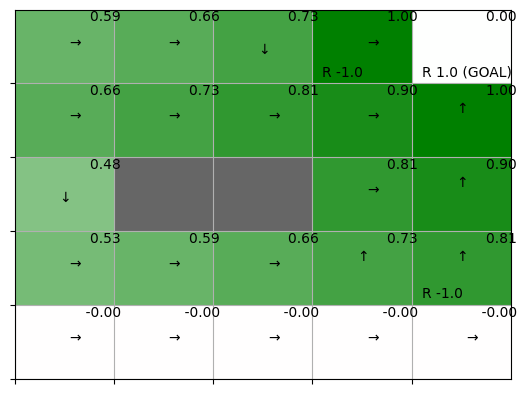

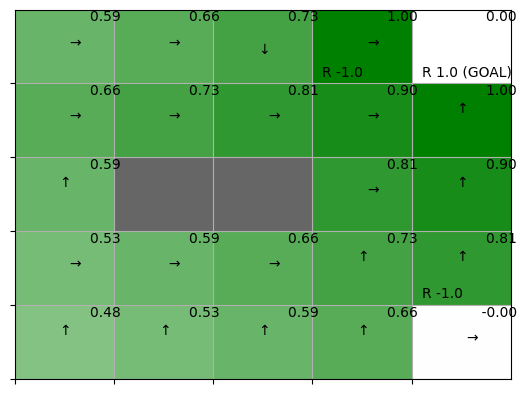

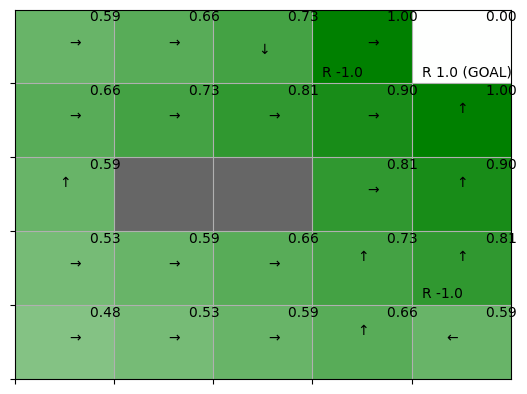

In [21]:
from collections import defaultdict


def argmax(d):
    max_value = max(d.values())
    max_key = 0
    for key, value in d.items():
        if value == max_value:
            max_key = key
    return max_key


def greedy_policy(V, env, gamma):
    pi = {}

    for state in env.states():
        action_values = {}

        for action in env.actions():
            next_state = env.next_state(state, action)
            r = env.reward(state, action, next_state)
            value = r + gamma * V[next_state]
            action_values[action] = value

        max_action = argmax(action_values)
        action_probs = {0: 0, 1: 0, 2: 0, 3: 0}
        action_probs[max_action] = 1.0
        pi[state] = action_probs
    return pi


def policy_iter(env, gamma, threshold=0.001, is_render=True):
    pi = defaultdict(lambda: {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25})
    V = defaultdict(lambda: 0)

    while True:
        V = policy_eval(pi, V, env, gamma, threshold)  # 평가
        new_pi = greedy_policy(V, env, gamma)          # 개선

        if is_render:
            env.render_v(V, pi)

        if new_pi == pi:  # 갱신 여부 확인
            break
        pi = new_pi

    return pi

if __name__ == '__main__':
    env = GridWorld()
    gamma = 0.9
    pi = policy_iter(env, gamma)

### Value iteration - 가치반복법

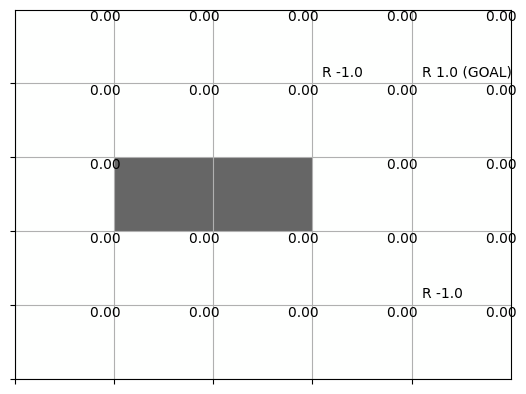

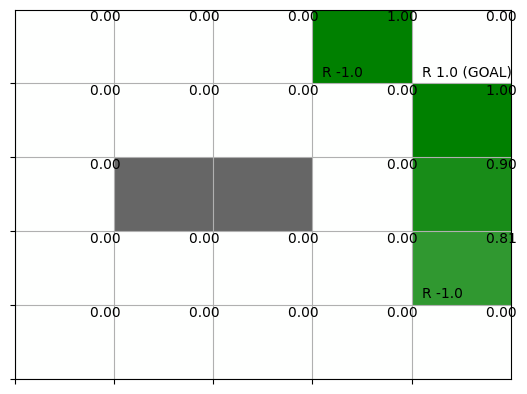

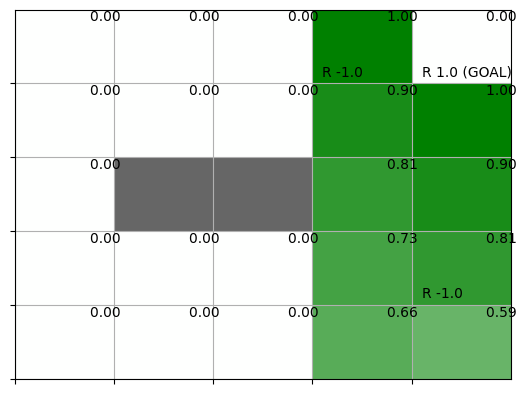

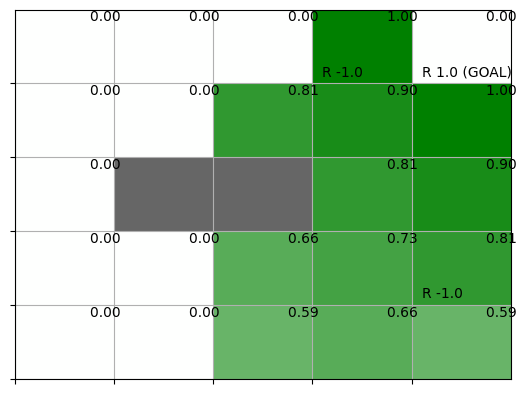

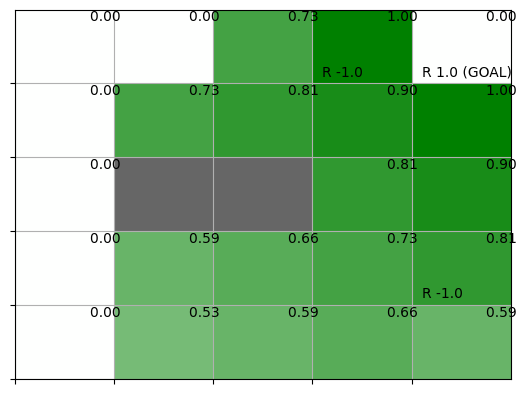

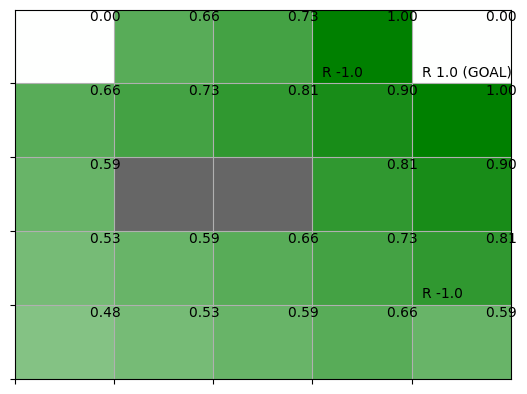

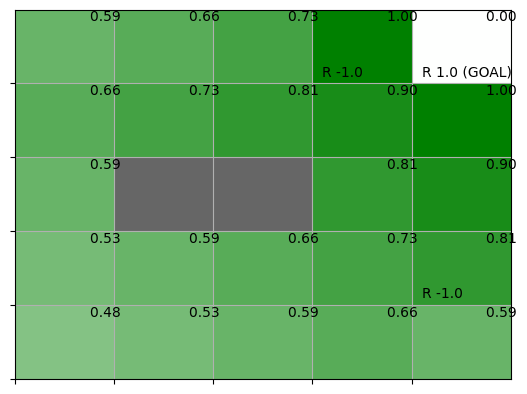

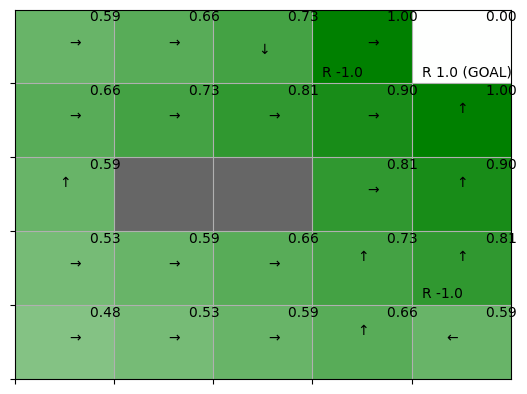

In [22]:
from collections import defaultdict


def value_iter_onestep(V, env, gamma):
    for state in env.states():       # 모든 상태에 차례로 접근
        if state == env.goal_state:  # 목표 상태에서의 가치 함수는 항상 0
            V[state] = 0
            continue

        action_values = []
        for action in env.actions():  # 모든 행동에 차례로 접근
            next_state = env.next_state(state, action)
            r = env.reward(state, action, next_state)
            value = r + gamma * V[next_state]  # 새로운 가치 함수
            action_values.append(value)

        V[state] = max(action_values)  # 최댓값 추출
    return V


def value_iter(V, env, gamma, threshold=0.001, is_render=True):
    while True:
        if is_render:
            env.render_v(V)

        old_V = V.copy()  # 갱신 전 가치 함수
        V = value_iter_onestep(V, env, gamma)

        # 갱신된 양의 최댓값 구하기
        delta = 0
        for state in V.keys():
            t = abs(V[state] - old_V[state])
            if delta < t:
                delta = t

        # 임계값과 비교
        if delta < threshold:
            break
    return V


# [그림 4-24] 및 [그림 4-25]
if __name__ == '__main__':
    V = defaultdict(lambda: 0)
    env = GridWorld()
    gamma = 0.9

    V = value_iter(V, env, gamma)  # 최적 가치 함수 찾기

    pi = greedy_policy(V, env, gamma)  # 최적 정책 찾기
    env.render_v(V, pi)